In [1]:
%load_ext autotime

In [2]:
import tempfile
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import display, Markdown, JSON
from astropy import stats
from astropy.io import fits
from google.cloud import firestore
from loguru import logger
from matplotlib.figure import Figure
from panoptes.utils.images import bayer
from panoptes.utils.images import fits as fits_utils
from panoptes.utils.serializers import from_json
from panoptes.utils.time import current_time

from panoptes.pipeline.observation import make_stamps
from panoptes.pipeline.utils import plot

firestore_db = firestore.Client(project='panoptes-exp')

sb.set_theme()

logger.remove()

time: 1.62 s


In [3]:
current_time()

<Time object: scale='utc' format='datetime' value=2022-06-17 01:23:15.924414>

time: 6.08 ms


# Process an observation

## Setup the processing

In [4]:
# Default input parameters (replaced in next cell)
sequence_id = 'PAN023_548ef7_20220613T072651'  # e.g. PAN012_358d0f_20191005T112325

# Unused option for now. See below.
# vmag_min = 6
# vmag_max = 14

position_column_x = 'catalog_wcs_x'
position_column_y = 'catalog_wcs_y'

input_bucket = 'panoptes-images-processed'

# JSON string of additional settings.
observation_settings = '{}'
output_dir = tempfile.TemporaryDirectory().name

image_status = 'MATCHED'
base_url = 'https://storage.googleapis.com'

time: 10.9 ms


In [5]:
# Set up output directory and filenames.
output_dir = Path(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

observation_store_path = output_dir / 'observation.h5'

time: 2.44 ms


In [6]:
observation_settings = from_json(observation_settings)
observation_settings['output_dir'] = output_dir

time: 1.51 ms


Fetch all the image documents from the metadata store. We then filter based off image status and measured properties.

In [7]:
unit_id, camera_id, sequence_time = sequence_id.split('_')

# Get sequence information
sequence_doc_path = f'units/{unit_id}/observations/{sequence_id}'
sequence_doc_ref = firestore_db.document(sequence_doc_path)

time: 1.54 ms


In [8]:
sequence_info = sequence_doc_ref.get().to_dict()

exptime = sequence_info['total_exptime'] / sequence_info['num_images']
sequence_info['exptime'] = int(exptime)

time: 142 ms


In [9]:
pd.json_normalize(sequence_info, sep='_').T

0
received_time              2022-06-13 09:31:56.303000+00:00
time                              2022-06-13 07:26:51+00:00
status                                              CREATED
sequence_id                   PAN023_548ef7_20220613T072651
total_exptime                                        5355.0
num_images                                               45
unit_id                                              PAN023
field_name                         Comet C2017 K2 PANSTARRS
software_version           POCSv0.8.1.post0.dev20+g37e4280c
exptime                                                 119
coordinates_mount_ra                                 271.25
coordinates_mount_dec                              7.582778
camera_serial_number                           212242000214
camera_camera_id                                     548ef7
camera_lens_serial_number                         RL0922122

time: 12.2 ms


In [10]:
# Get and show the metadata about the observation.
matched_query = sequence_doc_ref.collection('images').where('status', '==', image_status)
matched_docs = [d.to_dict() for d in matched_query.stream()]
images_df = pd.json_normalize(matched_docs, sep='_')

# Set a time index.
images_df.time = pd.to_datetime(images_df.time)
images_df = images_df.set_index(['time']).sort_index()

num_frames = len(images_df)
print(f'Found {num_frames} images in observation')

Found 45 images in observation
time: 378 ms


## Filter frames

Filter some of the frames based on the image properties as a whole.

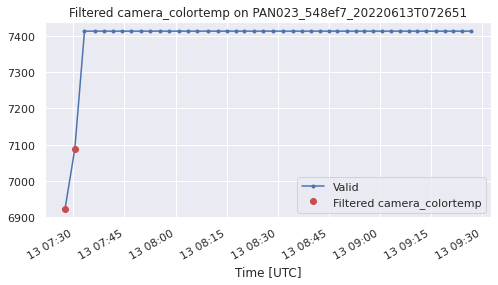

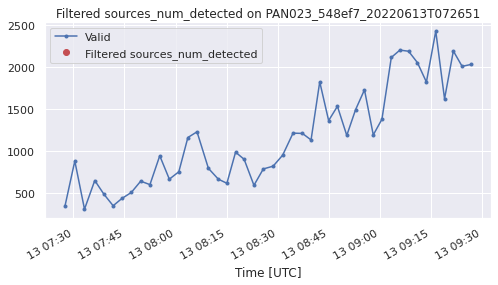

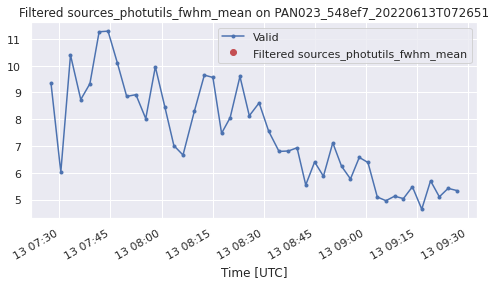

time: 936 ms


In [11]:
# Sigma filtering of certain stats
mask_columns = [
    'camera_colortemp',
    'sources_num_detected',
    'sources_photutils_fwhm_mean'
]

for mask_col in mask_columns:
    images_df[f'mask_{mask_col}'] = stats.sigma_clip(images_df[mask_col]).mask
    display(plot.filter_plot(images_df, mask_col, sequence_id))
    

images_df['is_masked'] = False
images_df['is_masked'] = images_df.filter(regex='mask_*').any(1)

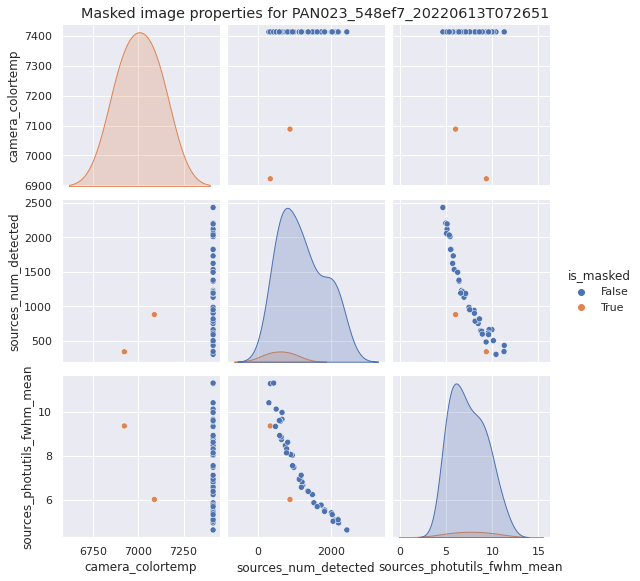

time: 2.44 s


In [12]:
pg = sb.pairplot(images_df[['is_masked', *mask_columns]], hue='is_masked')
pg.fig.suptitle(f'Masked image properties for {sequence_id}', y=1.01)
pg.fig.set_size_inches(9, 8);

In [13]:
# Get the unfiltered frames
images_df = images_df.query('is_masked==False')

num_frames = len(images_df)
print(f'Frames after filtering: {num_frames}')

Frames after filtering: 43
time: 8.11 ms


In [14]:
if num_frames < 10:
    raise RuntimeError(f'Cannot process with less than 10 frames,have {num_frames}')

time: 3.21 ms


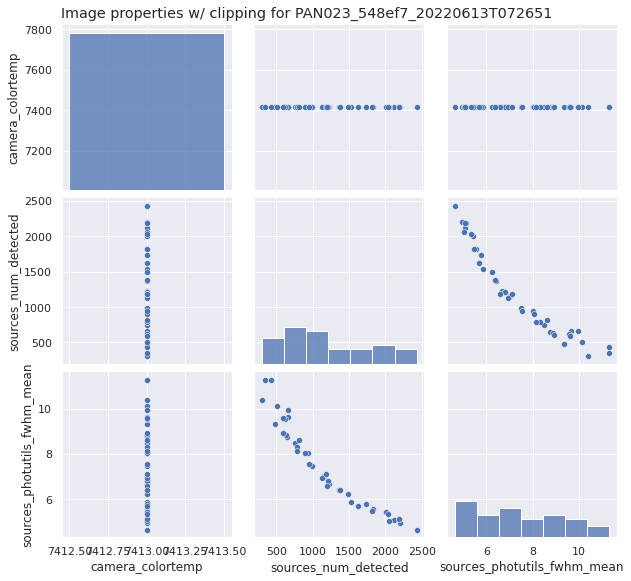

time: 1.75 s


In [15]:
pg = sb.pairplot(images_df[mask_columns])
pg.fig.suptitle(f'Image properties w/ clipping for {sequence_id}', y=1.01)

pg.fig.set_size_inches(9, 8);

In [16]:
# Save (most of) the images info to the observation store.
images_df.select_dtypes(exclude='object').to_hdf(observation_store_path, key='images', format='table', errors='ignore')

time: 47.8 ms


## Load metadata for images

In [17]:
# Build the joined metadata file.
sources = list()
for image_id in images_df.uid:
    blob_path = f'gcs://{input_bucket}/{image_id.replace("_", "/")}-sources.parquet'
    try:
        sources.append(pd.read_parquet(blob_path).astype(np.float32, errors='ignore'))
    except FileNotFoundError:
        print(f'Error finding {blob_path}, skipping')

sources_df = pd.concat(sources).sort_index()
del sources

time: 10.5 s


## Filter stars

Now that we have images of a sufficient quality, filter the star detections themselves.

We get the mean metadata values for each star and use that to filter any stellar outliers based on a few properties of the observation as a whole. 

In [18]:
# Use the mean value for the observation for each source.
sample_source_df = sources_df.groupby('picid').mean()

time: 27.7 ms


In [19]:
num_sources = len(sample_source_df)
print(f'Sources before filtering: {num_sources}')

Sources before filtering: 2756
time: 1 ms


In [20]:
frame_count = sources_df.groupby('picid').catalog_vmag.count()
exptime = images_df.camera_exptime.mean()

# Mask sources that don't appear in all (filtered) frames.
sample_source_df['frame_count'] = frame_count

time: 7.25 ms


In [21]:
sample_source_df.eval('mask_frame_count = frame_count!=frame_count.max()', inplace=True)

time: 13.1 ms


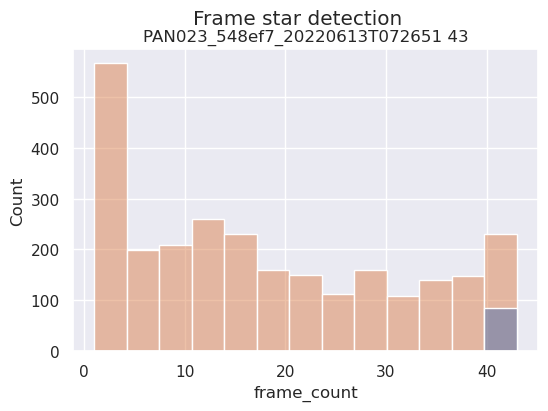

time: 453 ms


In [22]:
fig = Figure()
fig.set_dpi(100)
ax = fig.subplots()

sb.histplot(data=sample_source_df, x='frame_count', hue=f'mask_frame_count', ax=ax, legend=False)
ax.set_title(f'{sequence_id} {num_frames}')

fig.suptitle(f'Frame star detection')
fig

See [gini coefficient](https://photutils.readthedocs.io/en/stable/api/photutils.morphology.gini.html) info here.

In [23]:
# Sigma clip columns.
clip_columns = [
    'catalog_vmag',
    'photutils_gini',
    'photutils_fwhm',
]

# Display in pair plot columns.
pair_columns = [
    'catalog_sep',
    'photutils_eccentricity',
    'photutils_background_mean',
    'catalog_wcs_x_int',
    'catalog_wcs_y_int',
    'is_masked',
]

time: 1.15 ms


In [24]:
for mask_col in clip_columns:
    sample_source_df[f'mask_{mask_col}'] = stats.sigma_clip(sample_source_df[mask_col]).mask
    
# sample_source_df.eval('mask_catalog_vmag = catalog_vmag > @vmag_max or catalog_vmag < @vmag_min', inplace=True)

time: 11.4 ms


In [25]:
sample_source_df['is_masked'] = False
sample_source_df['is_masked'] = sample_source_df.filter(regex='mask_*').any(1)

time: 5.65 ms


In [26]:
display(Markdown('Number of stars filtered by type (with overlap):'))
display(Markdown(sample_source_df.filter(regex='mask_').sum(0).sort_values(ascending=False).to_markdown()))

Number of stars filtered by type (with overlap):

|                     |    0 |
|:--------------------|-----:|
| mask_frame_count    | 2671 |
| mask_photutils_fwhm |  203 |
| mask_catalog_vmag   |  125 |
| mask_photutils_gini |   13 |

time: 14.5 ms


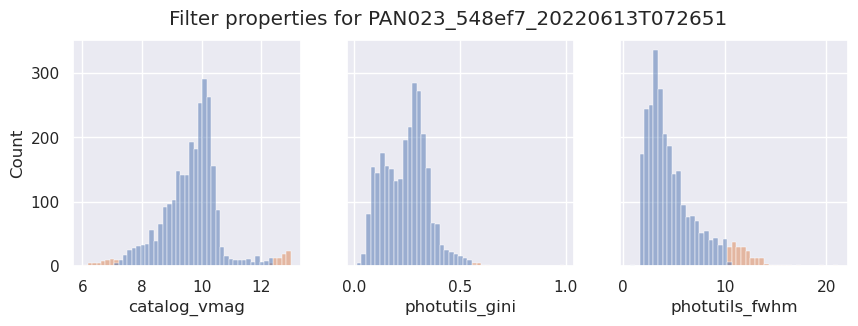

time: 920 ms


In [27]:
fig = Figure()
fig.set_dpi(100)
fig.set_size_inches(10, 3)
axes = fig.subplots(ncols=len(clip_columns), sharey=True)
for i, col in enumerate(clip_columns):
    sb.histplot(data=sample_source_df, x=col, hue=f'mask_{col}', ax=axes[i], legend=False)

fig.suptitle(f'Filter properties for {sequence_id}')
fig

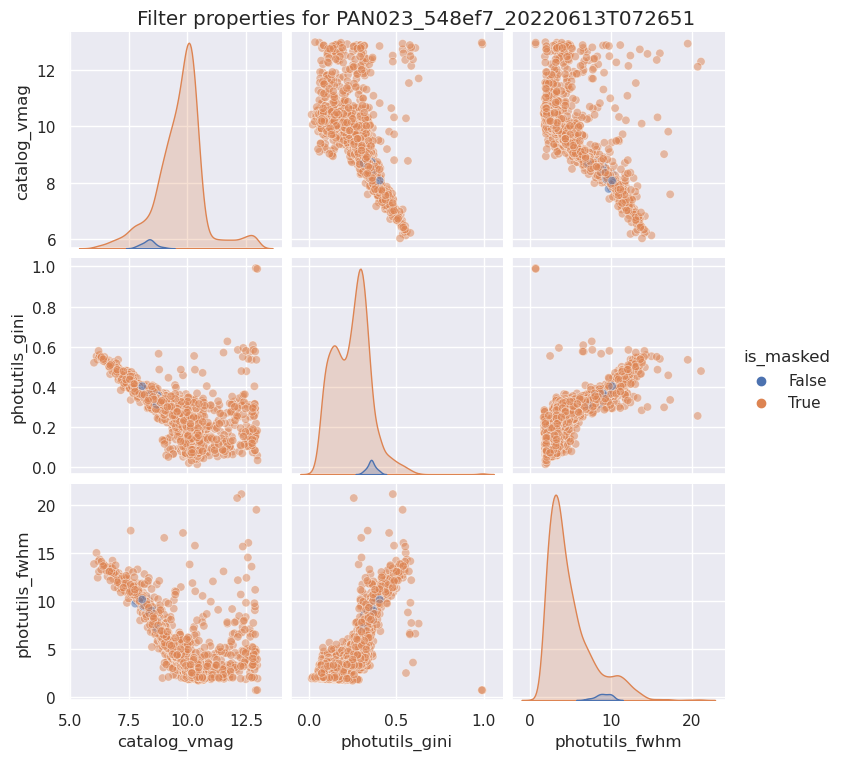

time: 3.36 s


In [28]:
pp = sb.pairplot(sample_source_df[clip_columns + ['is_masked']], hue='is_masked', plot_kws=dict(alpha=0.5))
pp.fig.suptitle(f'Filter properties for {sequence_id}', y=1.01)
pp.fig.set_dpi(100);

In [29]:
# pp = sb.pairplot(sample_source_df[clip_columns + pair_columns], hue='is_masked', plot_kws=dict(alpha=0.5))
# pp.fig.suptitle(f'Catalog vs detected properties for {sequence_id}', y=1.01);

time: 569 µs


In [30]:
# pp = sb.pairplot(sample_source_df.query('is_masked==False')[clip_columns + pair_columns], hue='is_masked', plot_kws=dict(alpha=0.5))
# pp.fig.suptitle(f'Catalog vs detected for filtered sources of {sequence_id}', y=1.01);

time: 412 µs


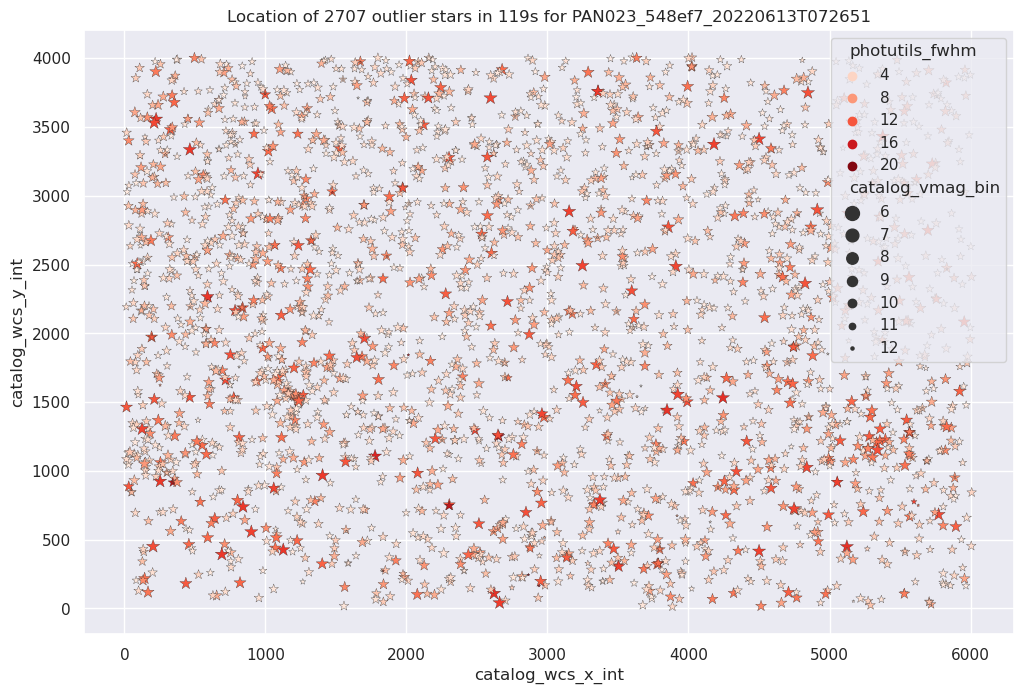

time: 785 ms


In [31]:
fig = Figure()
fig.set_dpi(100)
ax = fig.add_subplot()

plot_data = sample_source_df.query('is_masked == True')
sb.scatterplot(data=plot_data, 
               x='catalog_wcs_x_int', 
               y='catalog_wcs_y_int', 
               marker='*', 
               hue='photutils_fwhm',
               palette='Reds',
               edgecolor='k',
               linewidth=0.2,
               size='catalog_vmag_bin', sizes=(100, 5),
               ax=ax
              )
ax.set_title(f'Location of {len(plot_data)} outlier stars in {exptime:.0f}s for {sequence_id}')

fig.set_size_inches(12, 8)

fig

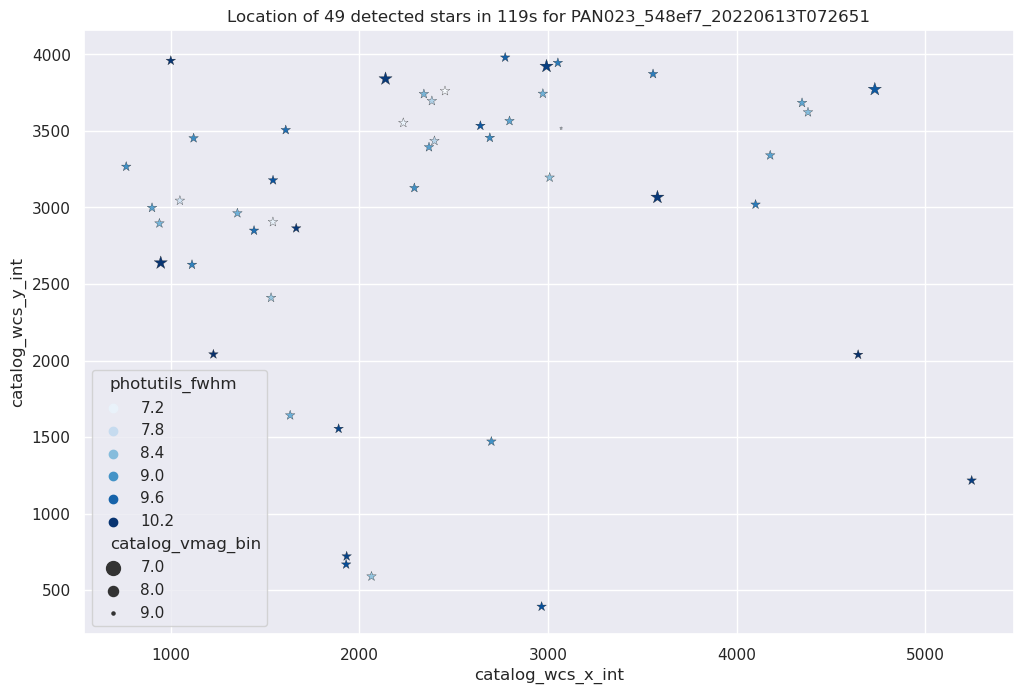

time: 492 ms


In [32]:
fig = Figure()
fig.set_dpi(100)
ax = fig.add_subplot()

plot_data = sample_source_df.query('is_masked == False')
sb.scatterplot(data=plot_data, 
               x='catalog_wcs_x_int', 
               y='catalog_wcs_y_int', 
               marker='*', 
               hue='photutils_fwhm',
               palette='Blues',
               edgecolor='k',
               linewidth=0.2,
               size='catalog_vmag_bin', sizes=(100, 5),
               ax=ax
              )
ax.set_title(f'Location of {len(plot_data)} detected stars in {exptime:.0f}s for {sequence_id}')

fig.set_size_inches(12, 8)

fig

In [33]:
# Get the sources that aren't filtered.
sources_df = sources_df.loc[sample_source_df.query('is_masked == False').index]

time: 20.7 ms


In [34]:
num_sources = len(sources_df.index.get_level_values('picid').unique())
print(f'Detected stars after filtering: {num_sources}')

Detected stars after filtering: 49
time: 1.6 ms


In [35]:
# Filter based on mean x and y movement of stars.
position_diffs = sources_df[['catalog_wcs_x_int', 'catalog_wcs_y_int']].groupby('picid').apply(lambda grp: grp - grp.mean())

# Get the airmass.
position_diffs = position_diffs.join(images_df.coordinates_airmass)

# Get the mask.
pixel_diff_mask = stats.sigma_clip(position_diffs.groupby('time').mean()).mask
x_mask = pixel_diff_mask[:, 0]
y_mask = pixel_diff_mask[:, 1]

print(f'Filtering {sum(x_mask | y_mask)} of {num_frames} frames based on pixel movement.')

filtered_time_index = sources_df.index.get_level_values('time').unique()[~(x_mask | y_mask)]

# Filter sources
sources_df = sources_df.reset_index('picid').loc[filtered_time_index].reset_index().set_index(['picid', 'time']).sort_index()
# Filter images
images_df = images_df.loc[filtered_time_index]
num_frames = len(filtered_time_index)
print(f'Now have {num_frames}')

Filtering 3 of 43 frames based on pixel movement.
Now have 40
time: 76 ms


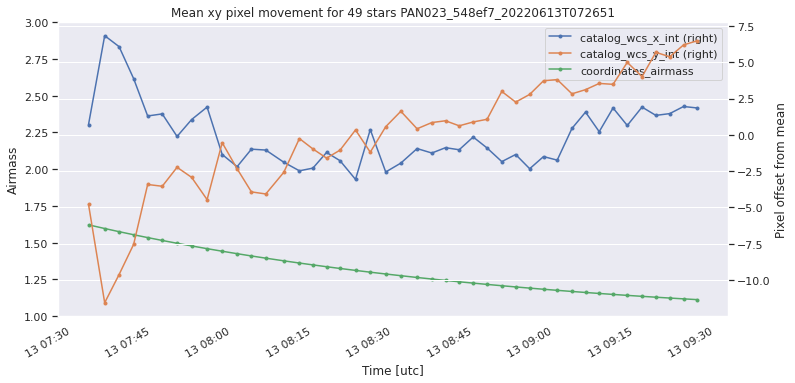

time: 525 ms


In [141]:
ax = time_mean.plot(marker='.', secondary_y=['catalog_wcs_x_int', 'catalog_wcs_y_int'])
# ax.figure.set_dpi(100)
ax.figure.set_size_inches(12, 6)

ax.set_ylim([1., 3.])
ax.set_ylabel('Airmass')
ax.set_xlabel('Time [utc]')

ax.right_ax.set_ylabel('Pixel offset from mean')
ax.set_title(f'Mean xy pixel movement for {num_sources} stars {sequence_id}');

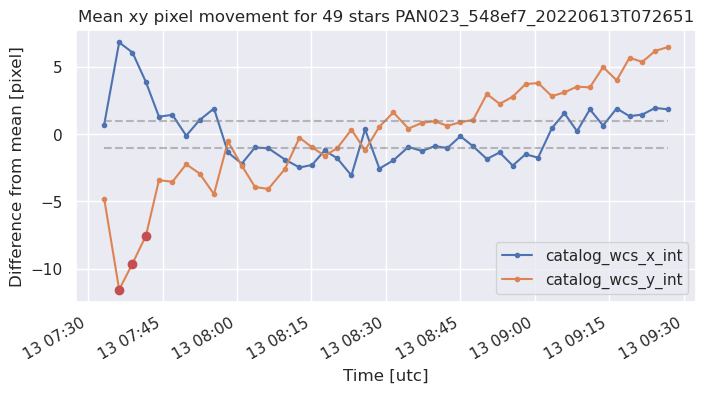

time: 436 ms


In [157]:
fig = Figure()
fig.set_dpi(100)
fig.set_size_inches(8, 4)
ax = fig.add_subplot()

x_col = 'time'
# x_col = 'coordinates_airmass'

position_diffs.groupby(x_col).mean().plot(y=['catalog_wcs_x_int', 'catalog_wcs_y_int'], marker='.', ax=ax)

# Mark outliers
time_mean = position_diffs.groupby(x_col).mean()
pd.DataFrame(time_mean[x_mask]['catalog_wcs_x_int']).plot(marker='o', c='r', ls='', ax=ax, legend=False)
pd.DataFrame(time_mean[y_mask]['catalog_wcs_y_int']).plot(marker='o', c='r', ls='', ax=ax, legend=False)

ax.hlines(1, time_mean.index[0], time_mean.index[-1], ls='--', color='grey', alpha=0.5)
ax.hlines(-1, time_mean.index[0], time_mean.index[-1], ls='--', color='grey', alpha=0.5)

# if time_mean.max().max() < 6:
    # ax.set_ylim([-6, 6])
# ax.set_xlim([1, 3])
    
ax.set_title(f'Mean xy pixel movement for {num_sources} stars {sequence_id}')
ax.set_xlabel('Time [utc]')
# ax.set_xlabel('Hourangle')
ax.set_ylabel('Difference from mean [pixel]')
fig

In [37]:
# Save sources to observation hdf5 file.
sources_df.to_hdf(observation_store_path, key='sources', format='table')
del sources_df

time: 41.9 ms


In [38]:
sources_df = pd.read_hdf(observation_store_path, key='sources')

time: 27.4 ms


In [39]:
sources_df

photutils_area  \
picid     time                                        
18516634  2022-06-13 07:33:15+00:00           126.0   
          2022-06-13 07:44:17+00:00           163.0   
          2022-06-13 07:47:00+00:00           150.0   
          2022-06-13 07:49:46+00:00           163.0   
          2022-06-13 07:52:29+00:00           169.0   
...                                             ...   
462772046 2022-06-13 09:16:29+00:00           158.0   
          2022-06-13 09:19:04+00:00           186.0   
          2022-06-13 09:21:39+00:00           165.0   
          2022-06-13 09:24:14+00:00           176.0   
          2022-06-13 09:26:47+00:00           171.0   

                                     photutils_background_centroid  \
picid     time                                                       
18516634  2022-06-13 07:33:15+00:00                     860.992859   
          2022-06-13 07:44:17+00:00                     933.338196   
          2022-06-13 07:47:00+00:00                     823.067078   
          2022-06-13 07:49:46+00:00                     773.263245   
          2022-06-13 07:52:29+00:00                     986.245789   
...                                                            ...   
462772046 2022-06-13 09:16:29+00:00                     720.818237   
          2022-06-13 09:19:04+00:00                     907.806335   
          2022-06-13 09:21:39+00:00                     884.439209   
          2022-06-13 09:24:14+00:00                     709.760254   
          2022-06-13 09:26:47+00:00                     781.524109   

                                     photutils_background_mean  \
picid     time                                                   
18516634  2022-06-13 07:33:15+00:00                 865.287109   
          2022-06-13 07:44:17+00:00                 854.961060   
          2022-06-13 07:47:00+00:00                 854.497498   
          2022-06-13 07:49:46+00:00                 851.022095   
          2022-06-13 07:52:29+00:00                 857.312622   
...                                                        ...   
462772046 2022-06-13 09:16:29+00:00                 534.641357   
          2022-06-13 09:19:04+00:00                 530.709106   
          2022-06-13 09:21:39+00:00                 527.630249   
          2022-06-13 09:24:14+00:00                 518.407715   
          2022-06-13 09:26:47+00:00                 524.406860   

                                     photutils_background_sum  \
picid     time                                                  
18516634  2022-06-13 07:33:15+00:00             109026.179688   
          2022-06-13 07:44:17+00:00             139358.656250   
          2022-06-13 07:47:00+00:00             128174.625000   
          2022-06-13 07:49:46+00:00             138716.609375   
          2022-06-13 07:52:29+00:00             144885.828125   
...                                                       ...   
462772046 2022-06-13 09:16:29+00:00              84473.335938   
          2022-06-13 09:19:04+00:00              98711.890625   
          2022-06-13 09:21:39+00:00              87058.984375   
          2022-06-13 09:24:14+00:00              91239.757812   
          2022-06-13 09:26:47+00:00              89673.570312   

                                     photutils_bbox_xmax  photutils_bbox_xmin  \
picid     time                                                                  
18516634  2022-06-13 07:33:15+00:00               2978.0               2960.0   
          2022-06-13 07:44:17+00:00               2978.0               2956.0   
          2022-06-13 07:47:00+00:00               2978.0               2958.0   
          2022-06-13 07:49:46+00:00               2976.0               2956.0   
          2022-06-13 07:52:29+00:00               2978.0               2958.0   
...                                                  ...                  ...   
462772046 2022-06-13 09:16:29+00:00               1009.0 

time: 39.7 ms


## Make stamp locations

In [40]:
max_stamp_size = 18

time: 471 µs


In [41]:
xy_catalog = pd.read_hdf(observation_store_path, 
                         key='sources', 
                         columns=[position_column_x, position_column_y]).reset_index().groupby('picid')

# Get max diff in xy positions.
x_catalog_diff = (xy_catalog.catalog_wcs_x.max() - xy_catalog.catalog_wcs_x.min()).max()
y_catalog_diff = (xy_catalog.catalog_wcs_y.max() - xy_catalog.catalog_wcs_y.min()).max()

if x_catalog_diff >= max_stamp_size or y_catalog_diff >= max_stamp_size:
    raise RuntimeError(f'Too much drift! {x_catalog_diff} {y_catalog_diff}')

stamp_width = 10 if x_catalog_diff < 10 else max_stamp_size
stamp_height = 10 if y_catalog_diff < 10 else max_stamp_size

# Determine stamp size
stamp_size = (stamp_width, stamp_height)
print(f'Using {stamp_size}.')

Using (10, 18).
time: 35.7 ms


In [42]:
# Get the mean positions
xy_mean = xy_catalog.mean()
xy_std = xy_catalog.std()

xy_mean = xy_mean.rename(columns=dict(
    catalog_wcs_x=f'{position_column_x}_mean',
    catalog_wcs_y=f'{position_column_y}_mean')
)
xy_std = xy_std.rename(columns=dict(
    catalog_wcs_x=f'{position_column_x}_std',
    catalog_wcs_y=f'{position_column_y}_std')
)

time: 6 ms


In [43]:
xy_mean = xy_mean.join(xy_std)

stamp_positions = xy_mean.apply(
    lambda row: bayer.get_stamp_slice(row[f'{position_column_x}_mean'],
                                      row[f'{position_column_y}_mean'],
                                      stamp_size=stamp_size,
                                      as_slices=False,
                                      ), axis=1, result_type='expand')

stamp_positions[f'{position_column_x}_mean'] = xy_mean[f'{position_column_x}_mean']
stamp_positions[f'{position_column_y}_mean'] = xy_mean[f'{position_column_y}_mean']
stamp_positions[f'{position_column_x}_std'] = xy_mean[f'{position_column_x}_std']
stamp_positions[f'{position_column_y}_std'] = xy_mean[f'{position_column_y}_std']

stamp_positions.rename(columns={0: 'stamp_y_min',
                                1: 'stamp_y_max',
                                2: 'stamp_x_min',
                                3: 'stamp_x_max'}, inplace=True)

time: 13 ms


In [44]:
stamp_positions.to_hdf(observation_store_path, key='positions', format='table')

time: 18.1 ms


## Extract stamps

In [45]:
# Get list of FITS file urls
fits_urls = [f'{base_url}/{input_bucket}/{image_id.replace("_", "/")}-reduced.fits.fz' for image_id in images_df.uid]

# Build the joined metadata file.
reference_image = None
diff_image = None
stack_image = None
for image_time, fits_url in zip(images_df.index, fits_urls):
    try:
        data = fits_utils.getdata(fits_url)
        if reference_image is None:
            reference_image = data
            diff_image = np.zeros_like(data)
            stack_image = np.zeros_like(data)
            
        # Get the diff and stack images.
        diff_image = diff_image + (data - reference_image)
        stack_image = stack_image + data
        
        # Get stamps data from positions.
        stamps = make_stamps(stamp_positions, data)
        
        # Add the time stamp to this index.
        time_index = [image_time] * num_sources
        stamps.index = pd.MultiIndex.from_arrays([stamps.index, time_index], names=('picid', 'time'))
        
        # Append directly to the observation store.
        stamps.to_hdf(observation_store_path, key='stamps', format='table', append=True)
    except Exception as e:
        print(f'Problem with {fits_url}: {e!r}')

time: 31.3 s


In [46]:
fits.HDUList([
    fits.PrimaryHDU(diff_image),
    fits.ImageHDU(stack_image / num_frames),
    ]).writeto(str(output_dir / f'stack-and-diff.fits'), overwrite=True)

time: 373 ms


In [47]:
image_title = sequence_id
if 'field_name' in sequence_info:
    image_title = f'{sequence_id} \"{sequence_info["field_name"]}\"'

time: 630 µs


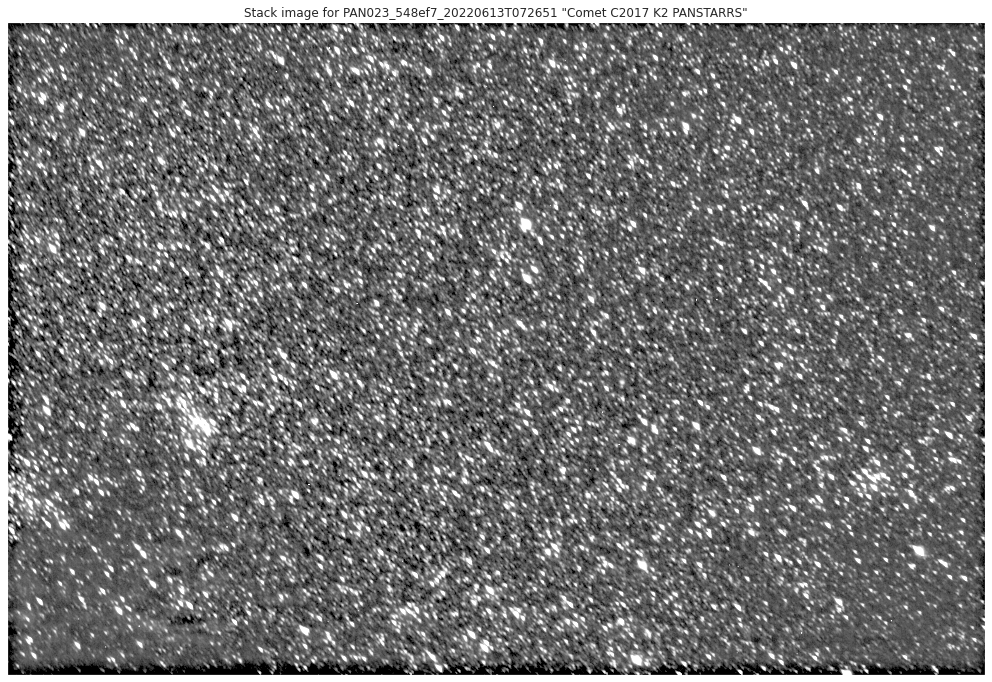

time: 2.63 s


In [48]:
plot.image_simple(stack_image, title=f'Stack image for {image_title}')

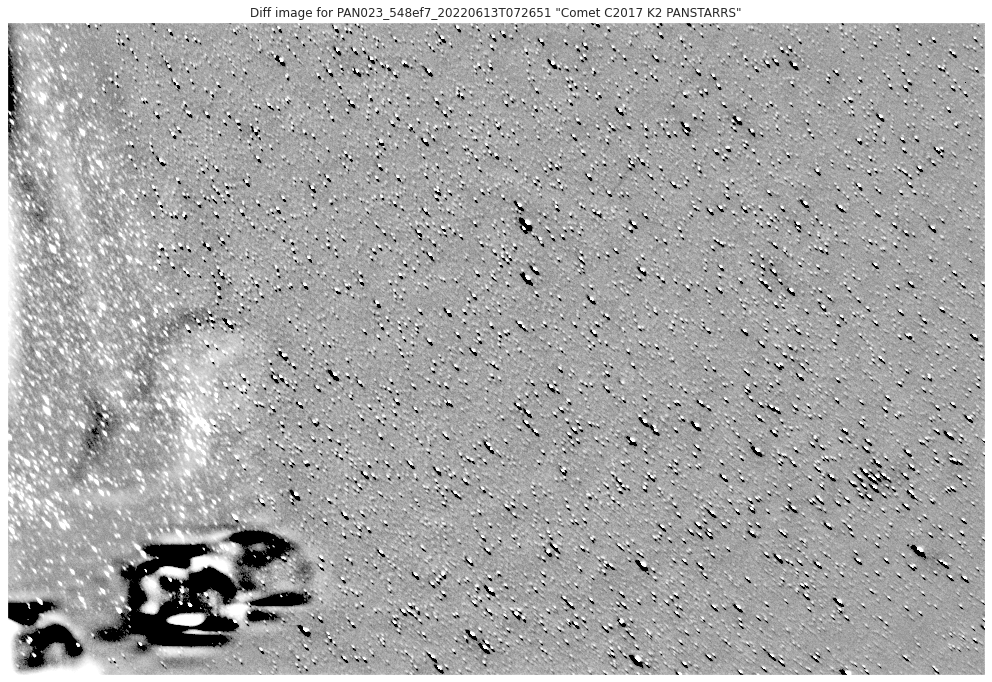

time: 2.48 s


In [49]:
plot.image_simple(diff_image, title=f'Diff image for {image_title}')

In [50]:
# Results
JSON(sequence_info, expanded=True)

<IPython.core.display.JSON object>

time: 3.13 ms


## Notebook environment info

In [51]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.33.0
ipykernel        : 6.13.0
ipywidgets       : 7.7.0
jupyter_client   : 7.3.1
jupyter_core     : 4.10.0
jupyter_server   : 1.17.0
jupyterlab       : 3.2.9
nbclient         : 0.6.4
nbconvert        : 6.5.0
nbformat         : 5.4.0
notebook         : 6.4.11
qtconsole        : not installed
traitlets        : 5.2.2
time: 1.06 s


In [52]:
current_time()

<Time object: scale='utc' format='datetime' value=2022-06-17 01:24:17.059433>

time: 5.51 ms
